In [ ]:
!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove
!apt-get update

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'nvidia-kernel-common-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-325-updates' for glob 'nvidia*'
Note, selecting 'nvidia-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-driver-binary' for glob 'nvidia*'
Note, selecting 'nvidia-331-dev' for glob 'nvidia*'
Note, selecting 'nvidia-304-updates-dev' for glob 'nvidia*'
Note, selecting 'nvidia-compute-utils-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-384-dev' for glob 'nvidia*'
Note, selecting 'nvidia-libopencl1-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-driver-440-server' for glob 'nvidia*'
Note, selecting 'nvidia-340-updates-uvm' for glob 'nvidia*'
Note, selecting 'nvidia-dkms-450-server' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-common' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-source-440-server' for glob 'nvidia*'
Note, selecting 'nvidia-331-updates-uvm' for glob 'nvidi

In [ ]:
!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!apt-get update
!apt-get install cuda-9.2

--2020-11-12 19:45:48--  https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Resolving developer.nvidia.com (developer.nvidia.com)... 152.199.0.24
Connecting to developer.nvidia.com (developer.nvidia.com)|152.199.0.24|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb?PQ1liER9G4SywzjixbpYR91brojs1l72J7DmY8yXJ7xTLzwtBIva6lRI96FTLFi9_sNtL6iyLFti5V78foG2Ml3Bs3nh_CgfssCVvpREoWgEOaE-mNDew5kRZNG9YCVzkHUioCjIN-_Nbjfk_f6dayRls-y_F3NruNusn5qTk-duGueOwQZ_wdfnR0yLhoS_s9Nr7tdGiVeSrYN6w90 [following]
--2020-11-12 19:45:48--  https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb?PQ1liER9G4SywzjixbpYR91brojs1l72J7DmY8yXJ7xTLzwtBIva6lRI96FTLFi9_sNtL6iyLFti5V78foG2Ml3Bs3nh_CgfssCVvpREoWgEOaE-mNDew5kRZNG9

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Wed_Apr_11_23:16:29_CDT_2018
Cuda compilation tools, release 9.2, V9.2.88


In [ ]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git

  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-zrdoz7p8
  Running command git clone -q git://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-zrdoz7p8
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-cp36-none-any.whl size=4307 sha256=fbadcb2b3d199b102f965eff6d4a2b3af45b241ed24806e4e2b424bd031e5d18
  Stored in directory: /tmp/pip-ephem-wheel-cache-ta1j7cxn/wheels/10/c2/05/ca241da37bff77d60d31a9174f988109c61ba989e4d4650516
Successfully built NVCCPlugin


In [ ]:
  %reload_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


In [ ]:
%%cu 
#include <iostream> 
using namespace std;
int main() 
{ 
    cout << "Welcome To GeeksforGeeks\n"; 
} 

Welcome To GeeksforGeeks



Cuda Assignment Question 1: Matrix multiplication

In [ ]:
%%cu
#include <stdio.h>
#include <stdlib.h>
#include <assert.h>
#include<vector>
#include<iostream>
#define BLOCK_SIZE 16


using namespace std;
void cpu_matrix_mult(int *h_a, int *h_b, int *h_result, int m, int n, int k) {
    for (int i = 0; i < m; ++i) 
    {
        for (int j = 0; j < k; ++j) 
        {
            int tmp = 0.0;
            for (int h = 0; h < n; ++h) 
            {
                tmp += h_a[i * n + h] * h_b[h * k + j];
            }
            h_result[i * k + j] = tmp;
        }
    }
}

__global__ void gpu_matrix_mult(int *a,int *b, int *c, int m, int n, int k)
{ 
    int row = blockIdx.y * blockDim.y + threadIdx.y; 
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    int sum = 0;
    if( col < k && row < m) 
    {
        for(int i = 0; i < n; i++) 
        {
            sum += a[row * n + i] * b[i * k + col];
        }
        c[row * k + col] = sum;
    }
} 

__global__ void gpu_square_matrix_mult(int *d_a, int *d_b, int *d_result, int n) 
{
    __shared__ int tile_a[BLOCK_SIZE][BLOCK_SIZE];
    __shared__ int tile_b[BLOCK_SIZE][BLOCK_SIZE];

    int row = blockIdx.y * BLOCK_SIZE + threadIdx.y;
    int col = blockIdx.x * BLOCK_SIZE + threadIdx.x;
    int tmp = 0;
    int idx;

    for (int sub = 0; sub < gridDim.x; ++sub) 
    {
        idx = row * n + sub * BLOCK_SIZE + threadIdx.x;
        if(idx >= n*n)
        {
            // n may not divisible by BLOCK_SIZE
            tile_a[threadIdx.y][threadIdx.x] = 0;
        }
        else
        {
            tile_a[threadIdx.y][threadIdx.x] = d_a[idx];
        }

        idx = (sub * BLOCK_SIZE + threadIdx.y) * n + col;
        if(idx >= n*n)
        {
            tile_b[threadIdx.y][threadIdx.x] = 0;
        }  
        else
        {
            tile_b[threadIdx.y][threadIdx.x] = d_b[idx];
        }
        __syncthreads();

        for (int k = 0; k < BLOCK_SIZE; ++k) 
        {
            tmp += tile_a[threadIdx.y][k] * tile_b[k][threadIdx.x];
        }
        __syncthreads();
    }
    if(row < n && col < n)
    {
        d_result[row * n + col] = tmp;
    }
}

__global__ void gpu_matrix_transpose(int* mat_in, int* mat_out, unsigned int rows, unsigned int cols) 
{
    unsigned int idx = blockIdx.x * blockDim.x + threadIdx.x;
    unsigned int idy = blockIdx.y * blockDim.y + threadIdx.y;

    if (idx < cols && idy < rows) 
    {
        unsigned int pos = idy * cols + idx;
        unsigned int trans_pos = idx * rows + idy;
        mat_out[trans_pos] = mat_in[pos];
    }
}

int main(int argc, char const *argv[])
{
    int m = 128, n = 128, k = 128;
    vector<int> sizes{128, 192, 256, 384, 512, 768, 1024, 1536, 2048, 4096};
    for (int i = 0; i < 10; i++){
      m = sizes[i];
      n = sizes[i];
      k = sizes[i];
      srand(777);
      int *h_a, *h_b, *h_c, *h_cc;
      cudaMallocHost((void **) &h_a, sizeof(int)*m*n);
      cudaMallocHost((void **) &h_b, sizeof(int)*n*k);
      cudaMallocHost((void **) &h_c, sizeof(int)*m*k);
      cudaMallocHost((void **) &h_cc, sizeof(int)*m*k);

      for (int i = 0; i < m; ++i) {
          for (int j = 0; j < n; ++j) {
              h_a[i * n + j] = rand() % 1024;
          }
      }

      for (int i = 0; i < n; ++i) {
          for (int j = 0; j < k; ++j) {
              h_b[i * k + j] = rand() % 1024;
          }
      }

      float gpu_elapsed_time_ms, cpu_elapsed_time_ms;

      cudaEvent_t start, stop;
      cudaEventCreate(&start);
      cudaEventCreate(&stop);

      cudaEventRecord(start, 0);
      int *d_a, *d_b, *d_c;
      cudaMalloc((void **) &d_a, sizeof(int)*m*n);
      cudaMalloc((void **) &d_b, sizeof(int)*n*k);
      cudaMalloc((void **) &d_c, sizeof(int)*m*k);

      cudaMemcpy(d_a, h_a, sizeof(int)*m*n, cudaMemcpyHostToDevice);
      cudaMemcpy(d_b, h_b, sizeof(int)*n*k, cudaMemcpyHostToDevice);

      unsigned int grid_rows = (m + BLOCK_SIZE - 1) / BLOCK_SIZE;
      unsigned int grid_cols = (k + BLOCK_SIZE - 1) / BLOCK_SIZE;
      dim3 dimGrid(grid_cols, grid_rows);
      dim3 dimBlock(BLOCK_SIZE, BLOCK_SIZE);
    
      if(m == n && n == k)
      {
          gpu_square_matrix_mult<<<dimGrid, dimBlock>>>(d_a, d_b, d_c, n);    
      }
      else
      {
          gpu_matrix_mult<<<dimGrid, dimBlock>>>(d_a, d_b, d_c, m, n, k);    
      }
      cudaMemcpy(h_c, d_c, sizeof(int)*m*k, cudaMemcpyDeviceToHost);
      cudaThreadSynchronize();
      cudaEventRecord(stop, 0);
      cudaEventSynchronize(stop);

      cudaEventElapsedTime(&gpu_elapsed_time_ms, start, stop);
      printf("Time elapsed on matrix multiplication of %dx%d . %dx%d on GPU: %f ms.\n\n", m, n, n, k, gpu_elapsed_time_ms);

      cudaEventRecord(start, 0);

      cpu_matrix_mult(h_a, h_b, h_cc, m, n, k);

      cudaEventRecord(stop, 0);
      cudaEventSynchronize(stop);
      cudaEventElapsedTime(&cpu_elapsed_time_ms, start, stop);
      printf("Time elapsed on matrix multiplication of %dx%d . %dx%d on CPU: %f ms.\n\n", m, n, n, k, cpu_elapsed_time_ms);

      int all_ok = 1;
      for (int i = 0; i < m; ++i)
      {
          for (int j = 0; j < k; ++j)
          {
              if(h_cc[i*k + j] != h_c[i*k + j])
              {
                  all_ok = 0;
              }
          }
      }

      if(all_ok)
      {
          printf("all results are correct!!!, speedup = %f\n", cpu_elapsed_time_ms / gpu_elapsed_time_ms);
      }
      else
      {
          printf("incorrect results\n");
      }

      cudaFree(d_a);
      cudaFree(d_b);
      cudaFree(d_c);
      cudaFreeHost(h_a);
      cudaFreeHost(h_b);
      cudaFreeHost(h_c);
      cudaFreeHost(h_cc);
    }
    return 0;
}


Time elapsed on matrix multiplication of 128x128 . 128x128 on GPU: 0.222240 ms.

Time elapsed on matrix multiplication of 128x128 . 128x128 on CPU: 7.631744 ms.

all results are correct!!!, speedup = 34.340099
Time elapsed on matrix multiplication of 192x192 . 192x192 on GPU: 0.261984 ms.

Time elapsed on matrix multiplication of 192x192 . 192x192 on CPU: 25.354496 ms.

all results are correct!!!, speedup = 96.778801
Time elapsed on matrix multiplication of 256x256 . 256x256 on GPU: 0.385856 ms.

Time elapsed on matrix multiplication of 256x256 . 256x256 on CPU: 60.053375 ms.

all results are correct!!!, speedup = 155.636749
Time elapsed on matrix multiplication of 384x384 . 384x384 on GPU: 0.720960 ms.

Time elapsed on matrix multiplication of 384x384 . 384x384 on CPU: 218.386246 ms.

all results are correct!!!, speedup = 302.910339
Time elapsed on matrix multiplication of 512x512 . 512x512 on GPU: 1.330368 ms.

Time elapsed on matrix multiplication of 512x512 . 512x512 on CPU: 606.52

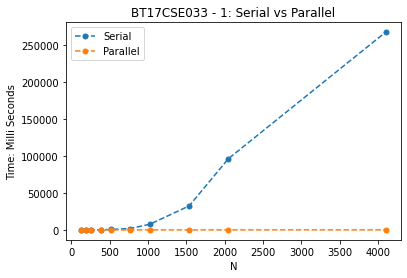

In [ ]:
import matplotlib.pyplot as plt 

x_axis = [128, 192, 256, 384, 512, 768, 1024, 1536, 2048, 4096]
y2 = [0.22, 0.26, .39, .72, 1.33, 3.52, 7.64, 22.4, 50, 122]
y1 = [7.63, 25.36, 60, 218, 606, 1912, 7710, 32501, 96440, 267512]
# plt.yscale('log', basey = 2)
plt.plot(x_axis, y1, linestyle = 'dashed', marker = 'o', markersize = 5, label = "Serial")
plt.plot(x_axis, y2, linestyle = 'dashed', marker = 'o', markersize = 5, label = "Parallel")

# naming the x axis 
plt.xlabel('N')
# naming the y axis 
plt.ylabel('Time: Milli Seconds')
# giving a title to my graph 
plt.title('BT17CSE033 - 1: Serial vs Parallel')
plt.legend()
plt.show()

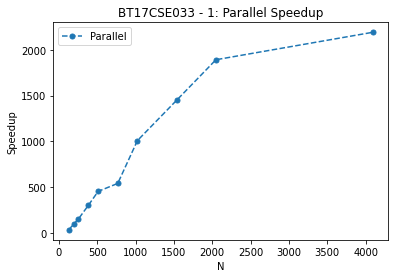

In [ ]:
import matplotlib.pyplot as plt 

x_axis = [128, 192, 256, 384, 512, 768, 1024, 1536, 2048, 4096]
y1 = [34.34, 96.78, 155, 302, 455, 542, 1009, 1450, 1892, 2192]
plt.plot(x_axis, y1, linestyle = 'dashed', marker = 'o', markersize = 5, label = "Parallel")

# naming the x axis
plt.xlabel('N')
# naming the y axis 
plt.ylabel('Speedup')
# giving a title to my graph 
plt.title('BT17CSE033 - 1: Parallel Speedup')
plt.legend()
plt.show()

Cuda Assignment Question 2: Irregular Graph Algorithm

In [ ]:
%%cu
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <math.h>
#include <iostream>
#include <vector>
#define DENSITY 16
#define MAX_WEIGHT 1000000
#define INF_DIST 1000000000
#define CPU_IMP 1
#define GPU_IMP 1
#define THREADS 2
#define VERTICES 1000
#define RAND_SEED 7777
#define THREADS_BLOCK 500
#define GIG 1000000000
#define ME 100000
#define CUDA_SAFE_CALL(ans) { gpuAssert((ans), __FILE__, __LINE__); }
using namespace std;

typedef float data_t;

inline void gpuAssert(cudaError_t code, char *file, int line, bool abort = true)
{
    if (code != cudaSuccess)
    {
        fprintf(stderr, "CUDA_SAFE_CALL: %s %s %d\n", cudaGetErrorString(code), file, line);
        if (abort) exit(code);
    }
}

int main() {

    srand(RAND_SEED);

    void setIntArrayValue(int* in_array, int array_size, int value);
    void setDataArrayValue(data_t* in_array, int array_size, data_t init_value);
    void initializeGraphZero(data_t* graph, int num_vertices);
    void constructGraphEdge(data_t* graph, int* edge_count, int num_vertices);
    void checkArray(int* a, int length);
    void checkArrayData(data_t* a, int length);

    void dijkstraCPUSerial(data_t* graph, data_t* node_dist, int* parent_node, int* visited_node, int num_vertices, int v_start);
    __global__ void closestNodeCUDA(data_t* node_dist, int* visited_node, int* global_closest, int num_vertices); 
    __global__ void cudaRelax(data_t* graph, data_t* node_dist, int* parent_node, int* visited_node, int* source);

    struct timespec diff(struct timespec start, struct timespec end);
    struct timespec start, end;
    struct timespec time_stamp[CPU_IMP];

    int graph_size      = VERTICES*VERTICES*sizeof(data_t);
    int int_array       = VERTICES*sizeof(int);
    int data_array      = VERTICES*sizeof(data_t);
    data_t* graph       = (data_t*)malloc(graph_size);
    data_t* node_dist   = (data_t*)malloc(data_array);
    int* parent_node    = (int*)malloc(int_array);
    int* edge_count     = (int*)malloc(int_array);
    int* visited_node   = (int*)malloc(int_array);
    int *pn_matrix      = (int*)malloc((CPU_IMP+GPU_IMP)*int_array);
    data_t* dist_matrix = (data_t*)malloc((CPU_IMP + GPU_IMP)*data_array);

    data_t* gpu_graph;
    data_t* gpu_node_dist;
    int* gpu_parent_node;
    int* gpu_visited_node;
    CUDA_SAFE_CALL(cudaMalloc((void**)&gpu_graph, graph_size));
    CUDA_SAFE_CALL(cudaMalloc((void**)&gpu_node_dist, data_array));
    CUDA_SAFE_CALL(cudaMalloc((void**)&gpu_parent_node, int_array));
    CUDA_SAFE_CALL(cudaMalloc((void**)&gpu_visited_node, int_array));

    int* closest_vertex = (int*)malloc(sizeof(int));
    int* gpu_closest_vertex;
    closest_vertex[0] = -1;
    CUDA_SAFE_CALL(cudaMalloc((void**)&gpu_closest_vertex, (sizeof(int))));
    CUDA_SAFE_CALL(cudaMemcpy(gpu_closest_vertex, closest_vertex, sizeof(int), cudaMemcpyHostToDevice));

    setIntArrayValue(edge_count, VERTICES, 0);
    setDataArrayValue(node_dist, VERTICES, INF_DIST);
    setIntArrayValue(parent_node, VERTICES, -1); 
    setIntArrayValue(visited_node, VERTICES, 0);
    initializeGraphZero(graph, VERTICES);
    constructGraphEdge(graph, edge_count, VERTICES);
    free(edge_count);

    int i;
    int origin = (rand() % VERTICES);
    int version = 0;
    clock_gettime(CLOCK_REALTIME, &start);
    dijkstraCPUSerial(graph, node_dist, parent_node, visited_node, VERTICES, origin);
    for (i = 0; i < VERTICES; i++) {
        pn_matrix[version*VERTICES + i] = parent_node[i];
        dist_matrix[version*VERTICES + i] = node_dist[i];
    }
    clock_gettime(CLOCK_REALTIME, &end);
    time_stamp[version] = diff(start, end);
    double time_taken = (end.tv_sec - start.tv_sec) * GIG + end.tv_nsec - start.tv_nsec;
    printf("\nCPU/Serial time (ms): %f\n", time_taken/ME);

    version++;
    cudaEvent_t exec_start, exec_stop;
    float elapsed_exec;
    CUDA_SAFE_CALL(cudaEventCreate(&exec_start));
    CUDA_SAFE_CALL(cudaEventCreate(&exec_stop));

    setDataArrayValue(node_dist, VERTICES, INF_DIST);
    setIntArrayValue(parent_node, VERTICES, -1);
    setIntArrayValue(visited_node, VERTICES, 0);
    node_dist[origin] = 0;

    CUDA_SAFE_CALL(cudaMemcpy(gpu_graph, graph, graph_size, cudaMemcpyHostToDevice));
    CUDA_SAFE_CALL(cudaMemcpy(gpu_node_dist, node_dist, data_array, cudaMemcpyHostToDevice));
    CUDA_SAFE_CALL(cudaMemcpy(gpu_parent_node, parent_node, int_array, cudaMemcpyHostToDevice));
    CUDA_SAFE_CALL(cudaMemcpy(gpu_visited_node, visited_node, int_array, cudaMemcpyHostToDevice));

    dim3 gridMin(1, 1, 1);
    dim3 blockMin(1, 1, 1);

    dim3 gridRelax(VERTICES / THREADS_BLOCK, 1, 1);
    dim3 blockRelax(THREADS_BLOCK, 1, 1);           

    CUDA_SAFE_CALL(cudaEventRecord(exec_start));
    for (int i = 0; i < VERTICES; i++) {
        closestNodeCUDA <<<gridMin, blockMin>>>(gpu_node_dist, gpu_visited_node, gpu_closest_vertex, VERTICES);            
        cudaRelax <<<gridRelax, blockRelax>>>(gpu_graph, gpu_node_dist, gpu_parent_node, gpu_visited_node, gpu_closest_vertex);
    }
    CUDA_SAFE_CALL(cudaEventRecord(exec_stop));
    
    CUDA_SAFE_CALL(cudaMemcpy(node_dist, gpu_node_dist, data_array, cudaMemcpyDeviceToHost));
    CUDA_SAFE_CALL(cudaMemcpy(parent_node, gpu_parent_node, int_array, cudaMemcpyDeviceToHost));
    CUDA_SAFE_CALL(cudaMemcpy(visited_node, gpu_visited_node, int_array, cudaMemcpyDeviceToHost));
    for (i = 0; i < VERTICES; i++) { 
        pn_matrix[version*VERTICES + i] = parent_node[i];
        dist_matrix[version*VERTICES + i] = node_dist[i];
    }

    CUDA_SAFE_CALL(cudaFree(gpu_graph));
    CUDA_SAFE_CALL(cudaFree(gpu_node_dist));
    CUDA_SAFE_CALL(cudaFree(gpu_parent_node));
    CUDA_SAFE_CALL(cudaFree(gpu_visited_node));


    printf("\nVertices: %d", VERTICES);

    CUDA_SAFE_CALL(cudaEventElapsedTime(&elapsed_exec, exec_start, exec_stop));
    printf("\n\nCUDA Time (ms): %7.9f\n", elapsed_exec);

    printf("\nSpeedup: %f\n", (time_taken/ME)/elapsed_exec);
}

void constructGraphEdge(data_t* graph, int* edge_count, int num_vertices) {

    int closestNode(data_t* node_dist, int* visited_node, int num_vertices);
    int i;
    int rand_vertex;
    int curr_num_edges;
    data_t weight;

    for (i = 1; i < num_vertices; i++) {
        rand_vertex = (rand() % i);                   
        weight = (rand() % MAX_WEIGHT) + 1;           
        graph[rand_vertex*num_vertices + i] = weight;
        graph[i*num_vertices + rand_vertex] = weight;
        edge_count[i] += 1;                            
        edge_count[rand_vertex] += 1;
    }

    for (i = 0; i < num_vertices; i++) {
        curr_num_edges = edge_count[i];
        while (curr_num_edges < DENSITY) {
            rand_vertex = (rand() % num_vertices);
            weight = (rand() % MAX_WEIGHT) + 1; 
            if ((rand_vertex != i) && (graph[i*num_vertices + rand_vertex] == 0)) {
                graph[i*num_vertices + rand_vertex] = weight;
                graph[rand_vertex*num_vertices + i] = weight;
                edge_count[i] += 1;
                curr_num_edges++;
            }
        }
    }
}

void setIntArrayValue(int* in_array, int array_size, int init_value) {
    int i;
    for (i = 0; i < array_size; i++) {
        in_array[i] = init_value;
    }
}

void initializeGraphZero(data_t* graph, int num_vertices) {
    int i, j;

    for (i = 0; i < num_vertices; i++) {
        for (j = 0; j < num_vertices; j++) { 
            graph[i*num_vertices + j] = (data_t)0;
        }
    }
}

void setDataArrayValue(data_t* in_array, int array_size, data_t init_value) {
    int i;
    for (i = 0; i < array_size; i++) {
        in_array[i] = init_value;
    }
}

struct timespec diff(struct timespec start, struct timespec end)
{
    struct timespec temp;
    if ((end.tv_nsec - start.tv_nsec)<0) {
        temp.tv_sec = end.tv_sec - start.tv_sec - 1;
        temp.tv_nsec = 1000000000 + end.tv_nsec - start.tv_nsec;
    }
    else {
        temp.tv_sec = end.tv_sec - start.tv_sec;
        temp.tv_nsec = end.tv_nsec - start.tv_nsec;
    }
    return temp;
}

int closestNode(data_t* node_dist, int* visited_node, int num_vertices) {
    data_t dist = INF_DIST + 1;
    int node = -1;
    int i;

    for (i = 0; i < num_vertices; i++) {
        if ((node_dist[i] < dist) && (visited_node[i] == 0)) {
            node = i;
            dist = node_dist[i];
        }
    }
    return node;
}

void dijkstraCPUSerial(data_t* graph, data_t* node_dist, int* parent_node, int* visited_node, int num_vertices, int v_start) {

    void setIntArrayValue(int* in_array, int array_size, int init_value);
    void setDataArrayValue(data_t* in_array, int array_size, data_t init_value);
    int closestNode(data_t* node_dist, int* visited_node, int num_vertices);

    setDataArrayValue(node_dist, VERTICES, INF_DIST);
    setIntArrayValue(parent_node, VERTICES, -1);
    setIntArrayValue(visited_node, VERTICES, 0);
    node_dist[v_start] = 0;

    int i, next;
    for (i = 0; i < num_vertices; i++) {
        int curr_node = closestNode(node_dist, visited_node, num_vertices);
        visited_node[curr_node] = 1;
        
        for (next = 0; next < num_vertices; next++) {
            int new_dist = node_dist[curr_node] + graph[curr_node*num_vertices + next];
            if ((visited_node[next] != 1)
                && (graph[curr_node*num_vertices + next] != (data_t)(0))
                && (new_dist < node_dist[next])) {
                node_dist[next] = new_dist;
                parent_node[next] = curr_node;
            }
        }
    }
}

__global__ void closestNodeCUDA(data_t* node_dist, int* visited_node, int* global_closest, int num_vertices) {
    data_t dist = INF_DIST + 1;
    int node = -1;
    int i;

    for (i = 0; i < num_vertices; i++) {
        if ((node_dist[i] < dist) && (visited_node[i] != 1)) {
            dist = node_dist[i];
            node = i;
        }
    }

    global_closest[0] = node;
    visited_node[node] = 1;
}

__global__ void cudaRelax(data_t* graph, data_t* node_dist, int* parent_node, int* visited_node, int* global_closest) {
    int next = blockIdx.x*blockDim.x + threadIdx.x;
    int source = global_closest[0];

    data_t edge = graph[source*VERTICES + next];
    data_t new_dist = node_dist[source] + edge;

    if ((edge != 0) &&
        (visited_node[next] != 1) &&
        (new_dist < node_dist[next])) {
        node_dist[next] = new_dist;
        parent_node[next] = source;
    }
}


CPU/Serial time (ms): 109.861530

Vertices: 1000

CUDA Time (ms): 105.380477905

Speedup: 1.042523



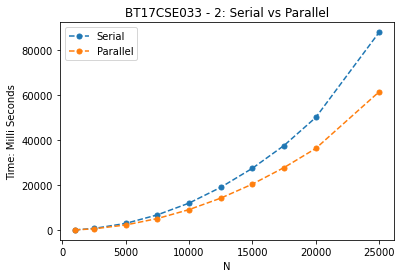

In [ ]:
import matplotlib.pyplot as plt 

x_axis = [1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 25000]
y1 = [109, 760, 2994, 6793, 12022, 19035, 27528, 37674, 50153, 88078]
y2 = [105, 593, 2310, 5153, 9134, 14236, 20487, 27860, 36360, 61593]
# plt.yscale('log', basey = 2)
plt.plot(x_axis, y1, linestyle = 'dashed', marker = 'o', markersize = 5, label = "Serial")
plt.plot(x_axis, y2, linestyle = 'dashed', marker = 'o', markersize = 5, label = "Parallel")

# naming the x axis 
plt.xlabel('N')
# naming the y axis 
plt.ylabel('Time: Milli Seconds')
# giving a title to my graph 
plt.title('BT17CSE033 - 2: Serial vs Parallel')
plt.legend()
plt.show()

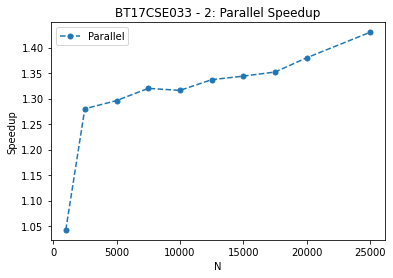

In [ ]:
import matplotlib.pyplot as plt 

x_axis = [1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 25000]
y1 = [1.0425, 1.28, 1.296, 1.32, 1.316, 1.337, 1.344, 1.352, 1.38, 1.43]
plt.plot(x_axis, y1, linestyle = 'dashed', marker = 'o', markersize = 5, label = "Parallel")

# naming the x axis
plt.xlabel('N')
# naming the y axis 
plt.ylabel('Speedup')
# giving a title to my graph 
plt.title('BT17CSE033 - 2: Parallel Speedup')
plt.legend()
plt.show()

Cuda Assignment Question 3: Big Integer Multiplication

In [ ]:
%%cu
#include <bits/stdc++.h>
#include <cstdio>
#include <cuComplex.h>
#include <assert.h>
#include <cufft.h>
#include <cstdlib>
#include <opencv2/core/core.hpp>
#include <opencv2/highgui/highgui.hpp>
#include <chrono>
#include <cstring> 
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#define N 256
#define BALANCE 2

using namespace std;
using namespace std::chrono;
using namespace cv;

typedef complex<float> base;
typedef float2 Complex_my;

__global__ void inplace_divide_invert(Complex_my *A, int n, int threads)
{
    int i = blockIdx.x * threads + threadIdx.x;
    if (i < n)
    {
        A[i].x /= n;
        A[i].y /= n;
    }
}

static __device__ __host__ inline Complex_my Add(Complex_my A, Complex_my B)
{
    Complex_my C;
    C.x = A.x + B.x;
    C.y = A.y + B.y;
    return C;
}

static __device__ __host__ inline Complex_my Multiply(Complex_my A, Complex_my B)
{
    Complex_my C;
    C.x = A.x * B.x - A.y * B.y;
    C.y = A.y * B.x + A.x * B.y;
    return C;
}

template <typename T>
ostream &operator<<(ostream &o, vector<T> v)
{
    if (v.size() > 0)
        o << v[0];
    for (unsigned i = 1; i < v.size(); i++)
        o << " " << v[i];
    return o << endl;
}

__global__ void bitrev_reorder(Complex_my *__restrict__ r, Complex_my *__restrict__ d, int s, size_t nthr, int n)
{
    int id = blockIdx.x * nthr + threadIdx.x;
    if (id < n and __brev(id) >> (32 - s) < n)
        r[__brev(id) >> (32 - s)] = d[id];
}

static __device__ __host__ inline Complex_my Inverse(Complex_my A)
{
    Complex_my C;
    C.x = -A.x;
    C.y = -A.y;
    return C;
}

__device__ void inplace_fft_inner(Complex_my *__restrict__ A, int i, int j, int len, int n, bool invert)
{
    if (i + j + len / 2 < n and j < len / 2)
    {
        Complex_my u, v;

        float angle = (2 * M_PI * j) / (len * (invert ? -1.0 : 1.0));
        v.x = cos(angle);
        v.y = sin(angle);

        u = A[i + j];
        v = Multiply(A[i + j + len / 2], v);
        A[i + j] = Add(u, v);
        A[i + j + len / 2] = Add(u, Inverse(v));
    }
}

__global__ void inplace_fft(Complex_my *__restrict__ A, int i, int len, int n, int threads, bool invert)
{
    int j = blockIdx.x * threads + threadIdx.x;
    inplace_fft_inner(A, i, j, len, n, invert);
}

__global__ void inplace_fft_outer(Complex_my *__restrict__ A, int len, int n, int threads, bool invert)
{
    int i = (blockIdx.x * threads + threadIdx.x);
    for (int j = 0; j < len / 2; j++)
    {
        inplace_fft_inner(A, i, j, len, n, invert);
    }
}

void fft(vector<base> &a, bool invert, int balance = 10, int threads = 512)
{
    int n = (int)a.size();
    int data_size = n * sizeof(Complex_my);
    Complex_my *data_array = (Complex_my *)malloc(data_size);
    for (int i = 0; i < n; i++)
    {
        data_array[i].x = a[i].real();
        data_array[i].y = a[i].imag();
    }
    
    Complex_my *A, *dn;
    cudaMalloc((void **)&A, data_size);
    cudaMalloc((void **)&dn, data_size);
    cudaMemcpy(dn, data_array, data_size, cudaMemcpyHostToDevice);
    int s = log2(n);

    bitrev_reorder<<<ceil(float(n) / threads), threads>>>(A, dn, s, threads, n);

    cudaDeviceSynchronize();
    for (int len = 2; len <= n; len <<= 1)
    {
        if (n / len > balance)
        {
            inplace_fft_outer<<<ceil((float)n / threads), threads>>>(A, len, n, threads, invert);
        }
        else
        {
            for (int i = 0; i < n; i += len)
            {
                float repeats = len / 2;
                inplace_fft<<<ceil(repeats / threads), threads>>>(A, i, len, n, threads, invert);
            }
        }
    }
    
    if (invert)
        inplace_divide_invert<<<ceil(n * 1.00 / threads), threads>>>(A, n, threads);

    Complex_my *result;
    result = (Complex_my *)malloc(data_size);
    cudaMemcpy(result, A, data_size, cudaMemcpyDeviceToHost);
    
    for (int i = 0; i < n; i++)
    {
        a[i] = base(result[i].x, result[i].y);
    }
    free(data_array);
    cudaFree(A);
    cudaFree(dn);
    return;
}

vector<int> mult(vector<int> a, vector<int> b, int balance, int threads)
{
    vector<base> fa(a.begin(), a.end()), fb(b.begin(), b.end());

    size_t n = 1;
    while (n < max(a.size(), b.size()))
        n <<= 1;
    n <<= 1;

    fa.resize(n), fb.resize(n);
 
    auto start = high_resolution_clock::now(); 

    fft(fa, false, balance, threads), fft(fb, false, balance, threads);

    for (size_t i = 0; i < n; ++i)
        fa[i] *= fb[i];

    fft(fa, true, balance, threads);


    auto stop = high_resolution_clock::now(); 
    auto duration = duration_cast<microseconds>(stop - start); 
    cout << "CPU Time(ms): " << duration.count() << endl;
    vector<int> res;
    res.resize(n);
    for (size_t i = 0; i < n; ++i)
        res[i] = int(fa[i].real() + 0.5);

    return res;
}

class FFT
{
public:
    void fft(vector<base> &a, bool invert)
    {
        int n = (int)a.size();

        for (int i = 1, j = 0; i < n; ++i)
        {
            int bit = n >> 1;
            for (; j >= bit; bit >>= 1)
                j -= bit;
            j += bit;
            if (i < j)
                swap(a[i], a[j]);
        }

        for (int len = 2; len <= n; len <<= 1)
        {
            double ang = 2 * M_PI / len * (invert ? 1 : -1);
            base wlen(cos(ang), sin(ang));
            for (int i = 0; i < n; i += len)
            {
                base w(1);
                for (int j = 0; j < len / 2; ++j)
                {
                    base u = a[i + j], v = a[i + j + len / 2] * w;
                    a[i + j] = u + v;
                    a[i + j + len / 2] = u - v;
                    w *= wlen;
                }
            }
        }

        if (invert)
            for (int i = 0; i < n; ++i)
                a[i] /= n;
        return;
    }

    vector<int> mult(vector<int> a, vector<int> b)
    {
        vector<base> fa(a.begin(), a.end()), fb(b.begin(), b.end());

        size_t n = 1;
        while (n < max(a.size(), b.size()))
            n <<= 1;
        n <<= 1;

        fa.resize(n), fb.resize(n);

        fft(fa, false), fft(fb, false);

        for (size_t i = 0; i < n; ++i)
            fa[i] *= fb[i];

        fft(fa, true);

        vector<int> res;
        res.resize(n);
        for (size_t i = 0; i < n; ++i)
            res[i] = int(fa[i].real() + 0.5);

        return res;
    }
};

int main()
{
    
    vector<int> fa(N);
    generate(fa.begin(), fa.end(), std::rand);
    vector<int> fb(N);
    generate(fb.begin(), fb.end(), std::rand);
    auto start = high_resolution_clock::now(); 
    auto result_parallel = mult(fa, fb, BALANCE, 256);
    auto stop = high_resolution_clock::now(); 
    auto duration = duration_cast<microseconds>(stop - start); 
    auto multiplier = FFT(); 
    start = high_resolution_clock::now(); 
    auto result_sequential = multiplier.mult(fa, fb);
    stop = high_resolution_clock::now(); 
    duration = duration_cast<microseconds>(stop - start);
    
    int n = 512;
    for (int i = 0; i < 3; i++){
        n *= 2;
        # define N n
        cout << "N: " << N << endl;
        vector<int> fa(N);
        generate(fa.begin(), fa.end(), std::rand);
        vector<int> fb(N);
        generate(fb.begin(), fb.end(), std::rand);
        auto result_parallel = mult(fa, fb, BALANCE, 256);
        auto multiplier = FFT(); 
        start = high_resolution_clock::now(); 
        auto result_sequential = multiplier.mult(fa, fb);
        stop = high_resolution_clock::now(); 
        duration = duration_cast<microseconds>(stop - start);
        cout << "GPU Time(ms): " << duration.count() << endl << endl;
    }
    return 0;
}

CPU Time(ms): 140035
N: 1024
CPU Time(ms): 4628
GPU Time(ms): 2863

N: 2048
CPU Time(ms): 8337
GPU Time(ms): 6148

N: 4096
CPU Time(ms): 15917
GPU Time(ms): 13369




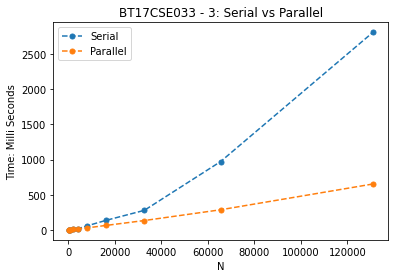

In [ ]:
import matplotlib.pyplot as plt 

x_axis = [256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072]
y2 = [1803, 2856, 4664, 8391, 15904, 58880, 137241, 278458, 970532, 2807506]
y2 = [i/1000 for i in y2]
y1 = [732, 1533, 3372, 7353, 14332, 29610, 64795, 133956, 286667, 653049]
y1 = [i/1000 for i in y1]
plt.plot(x_axis, y2, linestyle = 'dashed', marker = 'o', markersize = 5, label = "Serial")
plt.plot(x_axis, y1, linestyle = 'dashed', marker = 'o', markersize = 5, label = "Parallel")

# naming the x axis 
plt.xlabel('N')
# naming the y axis 
plt.ylabel('Time: Milli Seconds')
# giving a title to my graph 
plt.title('BT17CSE033 - 3: Serial vs Parallel')
plt.legend()
plt.show()

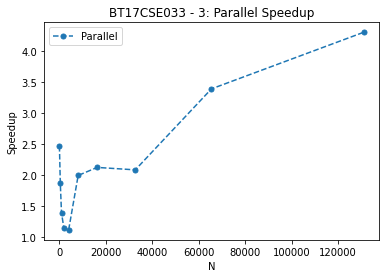

In [ ]:
import matplotlib.pyplot as plt 

x_axis = [128, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072]
y1 = [j/i for i, j in zip(y1, y2)]
plt.plot(x_axis, y1, linestyle = 'dashed', marker = 'o', markersize = 5, label = "Parallel")

# naming the x axis
plt.xlabel('N')
# naming the y axis 
plt.ylabel('Speedup')
# giving a title to my graph 
plt.title('BT17CSE033 - 3: Parallel Speedup')
plt.legend()
plt.show()